In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

filepath = r"C:\Users\vansh\AI and ML reading material\MakeMore-Implementing NLP models\names.txt"

In [2]:
#read in the dataset
words = open(filepath, 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("The total number of words in the dataset are: ",len(words))

The total number of words in the dataset are:  32033


In [4]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#build the dataset
block_size = 3 #context_length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape), print(Y.shape)

    return X, Y

import random
random.seed(3125)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182619, 3])
torch.Size([182619])
torch.Size([22804, 3])
torch.Size([22804])
torch.Size([22723, 3])
torch.Size([22723])


In [12]:
#MLP revisited 
n_embed = 10 #number of embedding dimensions
n_hidden = 200 #number of hidden units

g = torch.Generator().manual_seed(12345)
C = torch.randn((vocab_size, n_embed), generator=g, requires_grad=True) #generate the embeddings for each of the 27 characters
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g, requires_grad=True) #weight matrix of the first layer
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=False) * 0.01 
b2 = torch.randn(vocab_size, generator=g, requires_grad=False) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [13]:
import torch.nn.functional as F
#same optimization as last time
max_steps = 20000
batch_size = 32
lossi=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track statistics
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/  20000 : 3.3084
   1000/  20000 : 2.6461
   2000/  20000 : 2.8674
   3000/  20000 : 2.3533
   4000/  20000 : 2.1217
   5000/  20000 : 2.2072
   6000/  20000 : 2.5251
   7000/  20000 : 2.1254
   8000/  20000 : 2.0604
   9000/  20000 : 2.2142
  10000/  20000 : 2.4607
  11000/  20000 : 2.2867
  12000/  20000 : 2.7441
  13000/  20000 : 2.4116
  14000/  20000 : 2.3622
  15000/  20000 : 2.2994
  16000/  20000 : 1.9615
  17000/  20000 : 2.3284
  18000/  20000 : 1.8240
  19000/  20000 : 2.3152


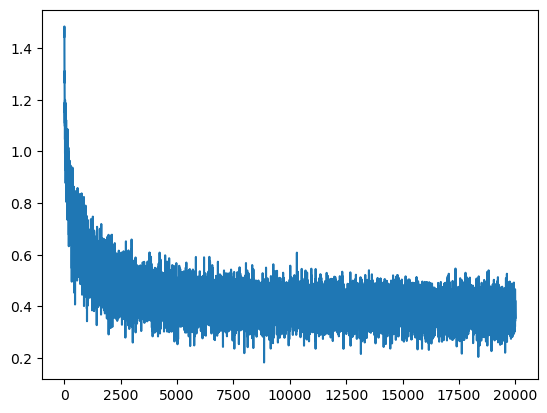

In [11]:
plt.plot(lossi)

The ideal random distribution will have the same probabilities for all the variables which will be 1/27. If we can we start from this point and the learn better probabilites it will be less computationally expensive. To do this we clip the weights of the neural nework by a constant, say 0.1

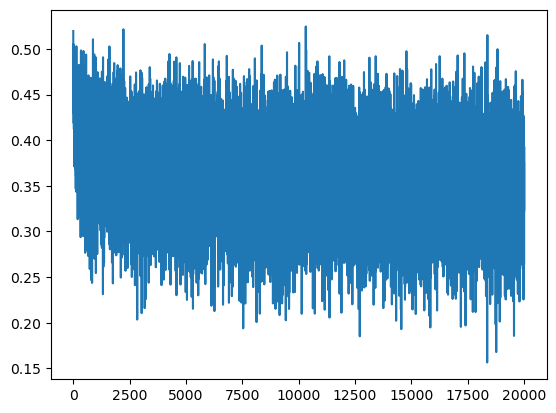

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    h = torch.tanh(embcat @ W1 + b1) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.2974042892456055
val 2.333411931991577


#### ------BATCH NORMALIZATION-------

In [16]:
#MLP revisited with batch normalization
n_embed = 10 #number of embedding dimensions
n_hidden = 200 #number of hidden units

g = torch.Generator().manual_seed(12345)
#generate the embeddings for each of the 27 characters
C = torch.randn((vocab_size, n_embed), generator=g, requires_grad=True)
#weight matrix of the first layer
#we have forecibly normalized the weight matrix using the kaiming initialization
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g, requires_grad=False) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=False) * 0.01 
b2 = torch.randn(vocab_size, generator=g, requires_grad=False) * 0

bngain = torch.ones((1, n_hidden), requires_grad=True)
bnbias = torch.zeros((1, n_hidden), requires_grad=True)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [17]:
import torch.nn.functional as F
#same optimization as last time
max_steps = 20000
batch_size = 32
lossi=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track statistics
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/  20000 : 3.3162
   1000/  20000 : 2.6977
   2000/  20000 : 2.8449
   3000/  20000 : 2.4865
   4000/  20000 : 2.2115
   5000/  20000 : 2.2735
   6000/  20000 : 2.2750
   7000/  20000 : 2.1497
   8000/  20000 : 1.9952
   9000/  20000 : 2.1704
  10000/  20000 : 2.4477
  11000/  20000 : 2.3375
  12000/  20000 : 2.6352
  13000/  20000 : 2.5314
  14000/  20000 : 2.2607
  15000/  20000 : 2.2338
  16000/  20000 : 1.8681
  17000/  20000 : 2.2543
  18000/  20000 : 1.9265
  19000/  20000 : 2.2513


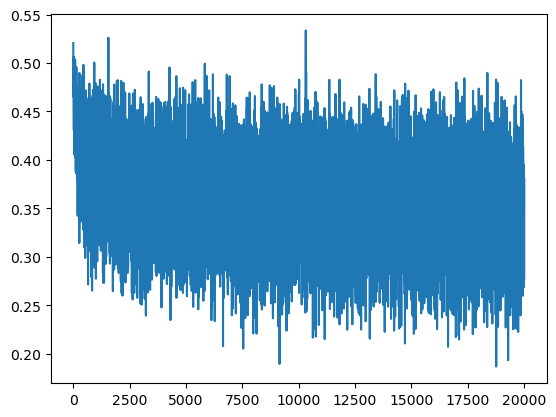

In [18]:
plt.plot(lossi)

In [19]:
@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.2219111919403076
val 2.2468183040618896


Applying batchnorm to the training creates an issue of predicting the output when a single input is given, because the network expects a batch of training samples. To rectify this, we can apply an extra training step 

In [20]:
#calibrate the batch norm at the end of the training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - bnmean) / bnstd + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.2219111919403076
val 2.2468454837799072


Or! We can calculate the mean of the whole training samples while training by calculating a running loss and running standard deviation

In [22]:
#MLP revisited with batch normalization and running loss
n_embed = 10 #number of embedding dimensions
n_hidden = 200 #number of hidden units

g = torch.Generator().manual_seed(12345)
#generate the embeddings for each of the 27 characters
C = torch.randn((vocab_size, n_embed), generator=g, requires_grad=True)
#weight matrix of the first layer
#we have forecibly normalized the weight matrix using the kaiming initialization
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g, requires_grad=False) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=False) * 0.01 
b2 = torch.randn(vocab_size, generator=g, requires_grad=False) * 0

bngain = torch.ones((1, n_hidden), requires_grad=True)
bnbias = torch.zeros((1, n_hidden), requires_grad=True)
bnmean_running = torch.zeros((1, n_hidden), requires_grad=False)
bnstd_running = torch.ones((1, n_hidden), requires_grad=False)


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [23]:
import torch.nn.functional as F
#same optimization as last time
max_steps = 20000
batch_size = 32
lossi=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias #batch normalization layer 
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track statistics
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/  20000 : 3.3162
   1000/  20000 : 2.6977
   2000/  20000 : 2.8449
   3000/  20000 : 2.4865
   4000/  20000 : 2.2115
   5000/  20000 : 2.2735
   6000/  20000 : 2.2750
   7000/  20000 : 2.1497
   8000/  20000 : 1.9952
   9000/  20000 : 2.1704
  10000/  20000 : 2.4477
  11000/  20000 : 2.3375
  12000/  20000 : 2.6352
  13000/  20000 : 2.5314
  14000/  20000 : 2.2607
  15000/  20000 : 2.2338
  16000/  20000 : 1.8681
  17000/  20000 : 2.2543
  18000/  20000 : 1.9265
  19000/  20000 : 2.2513


In [24]:
@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2258713245391846
val 2.250460147857666


Let's organise our code into classes and methods

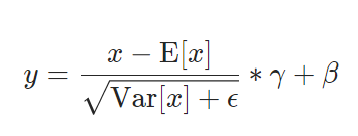

In [35]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        #create the weight matrix and normalize it with the kaiming limit
        self.weight = torch.randn((fan_in, fan_out), generator=g, requires_grad=False) / (fan_in)**0.5
        #create a bias parameter which represents the bais matrix
        self.bias = torch.zeros(fan_out, requires_grad=True) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trained with backprop
        self.gamma = torch.ones(dim, requires_grad=True)
        self.beta = torch.zeros(dim, requires_grad=True)
        #buffers (trained with a runnning 'momentum update')
        self.running_mean = torch.zeros(dim, requires_grad=True)
        self.running_std = torch.ones(dim, requires_grad=True)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) #batch variance

        else:
            xman = self.running_mean
            xvar = self.running_std

        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_mean + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return (self.gamma, self.beta)


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []




In [50]:
n_embed = 10 #the dimensionality of the character embedding vectors
n_hidden = 100 #number of hidden neurons in each of the layers
g = torch.Generator().manual_seed(1234567)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].weight *=0.1
    #all other layers: apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True
    

46497


In [51]:
#same optimization as before
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    if i >= 1000:
        break

      0/ 200000: 3.3037


layer 1 (      Tanh): mean -0.02, std 0.77, saturated: 22.72%
layer 3 (      Tanh): mean +0.03, std 0.72, saturated: 12.28%
layer 5 (      Tanh): mean +0.02, std 0.72, saturated: 10.22%
layer 7 (      Tanh): mean -0.01, std 0.71, saturated: 9.91%
layer 9 (      Tanh): mean +0.06, std 0.71, saturated: 11.06%


Text(0.5, 1.0, 'activation distribution')

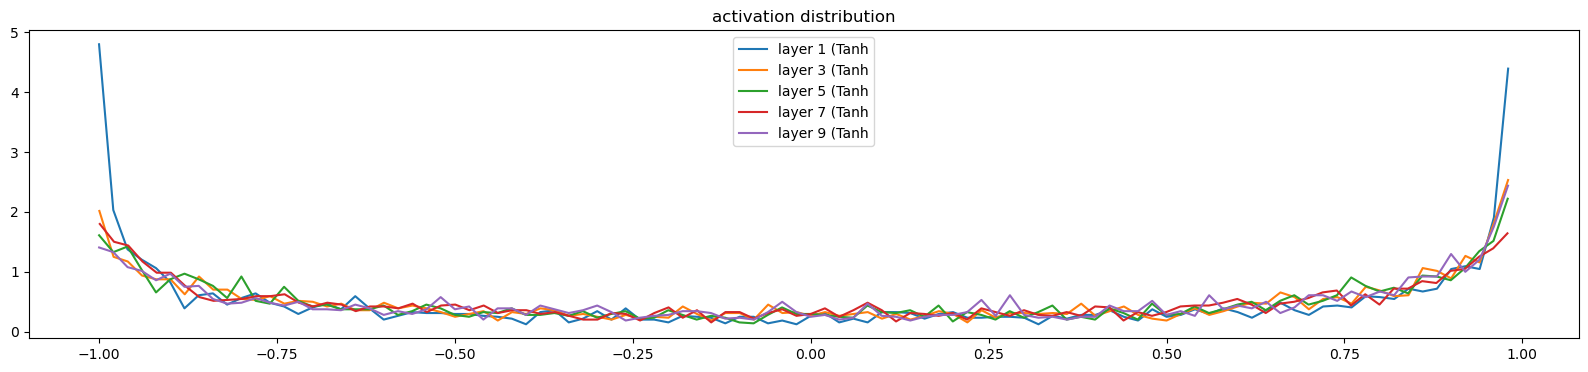

In [52]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Now if we were to change the initialization of the weight matrices from5/3 to let's say 3 ( which is a bit more extreme)

layer 1 (      Tanh): mean -0.02, std 0.77, saturated: 22.72%
layer 3 (      Tanh): mean +0.03, std 0.72, saturated: 12.28%
layer 5 (      Tanh): mean +0.02, std 0.72, saturated: 10.22%
layer 7 (      Tanh): mean -0.01, std 0.71, saturated: 9.91%
layer 9 (      Tanh): mean +0.06, std 0.71, saturated: 11.06%


Text(0.5, 1.0, 'activation distribution')

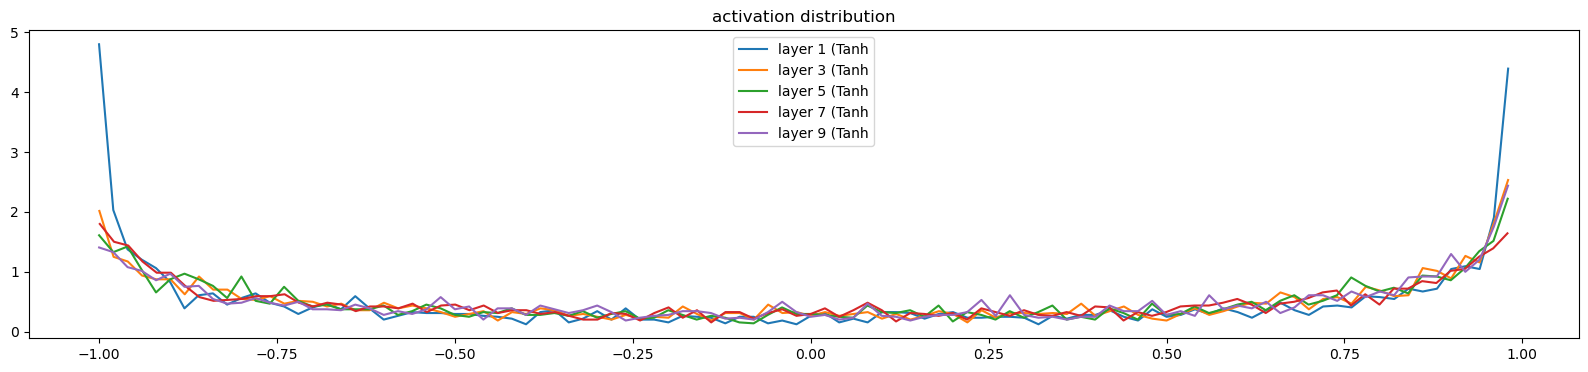

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

The saturation of neurons becomes to high which is not a good sign for neural network training. On the other hand if we initialize it with let's say 1/2 

layer 1 (      Tanh): mean -0.02, std 0.77, saturated: 22.72%
layer 3 (      Tanh): mean +0.03, std 0.72, saturated: 12.28%
layer 5 (      Tanh): mean +0.02, std 0.72, saturated: 10.22%
layer 7 (      Tanh): mean -0.01, std 0.71, saturated: 9.91%
layer 9 (      Tanh): mean +0.06, std 0.71, saturated: 11.06%


Text(0.5, 1.0, 'activation distribution')

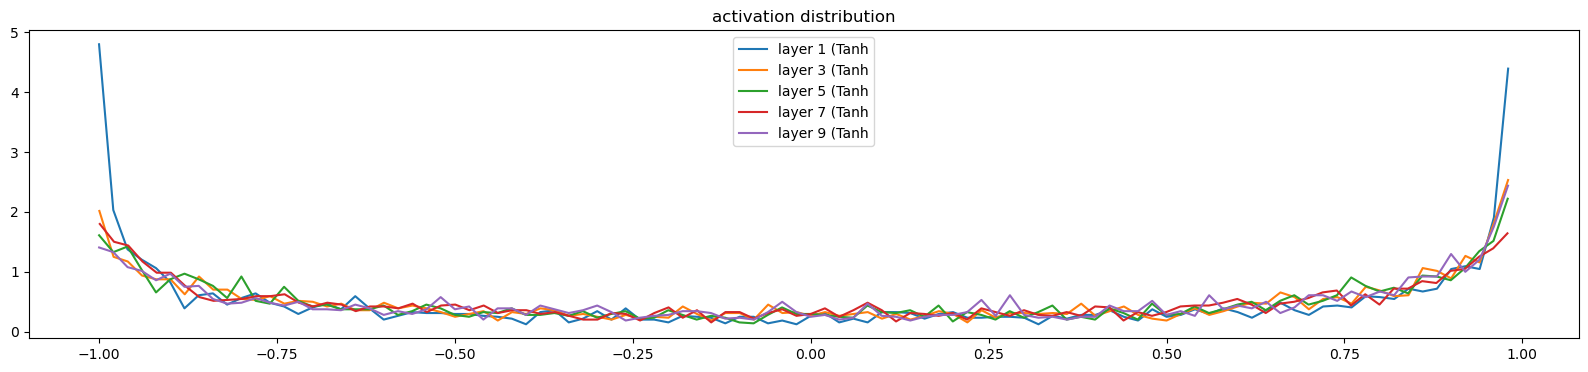

In [54]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

To visualize the gradients

In [60]:
n_embed = 10 #the dimensionality of the character embedding vectors
n_hidden = 100 #number of hidden neurons in each of the layers
g = torch.Generator().manual_seed(1234567)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].weight *=0.1
    #all other layers: apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True
    

46497


In [61]:
#same optimization as before
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i>= 1000: break

      0/ 200000: 3.3037


layer 1 (      Tanh): mean +0.000012, std 3.515592e-03
layer 3 (      Tanh): mean -0.000024, std 3.254143e-03
layer 5 (      Tanh): mean -0.000007, std 3.129554e-03
layer 7 (      Tanh): mean +0.000043, std 2.778269e-03
layer 9 (      Tanh): mean -0.000041, std 2.328978e-03


Text(0.5, 1.0, 'gradient distribution')

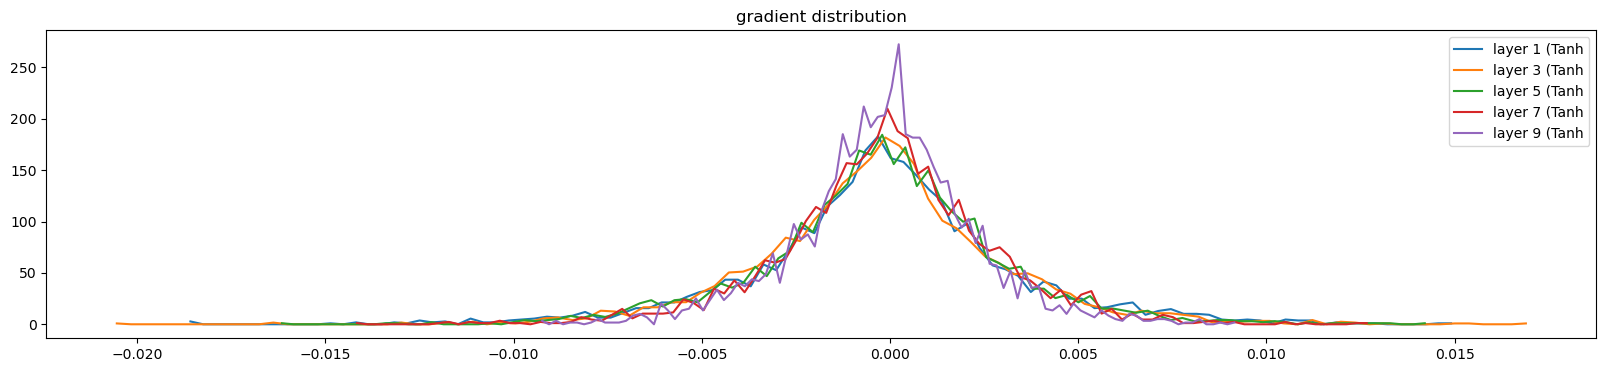

In [62]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

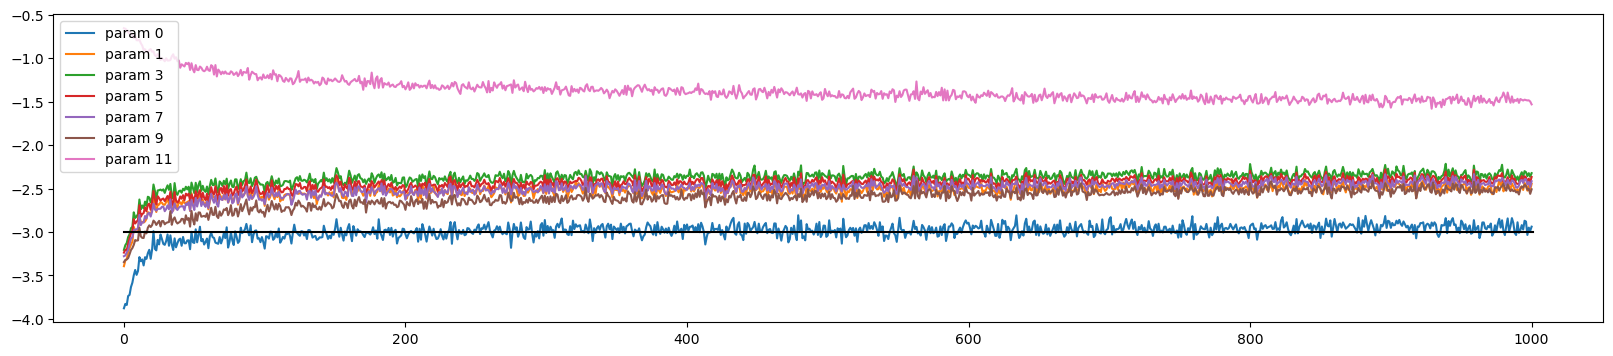

In [63]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [81]:
n_embed = 10 #the dimensionality of the character embedding vectors
n_hidden = 100 #number of hidden neurons in each of the layers
g = torch.Generator().manual_seed(1234567)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].gamma+=0.1
    #layers[-1].weight *=0.1
    #all other layers: apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True
    

47024


In [82]:
#same optimization as before
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i>= 10000: break

      0/ 200000: 3.8608
  10000/ 200000: 2.5136


layer 2 (      Tanh): mean +0.02, std 0.70, saturated: 16.53%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 16.00%
layer 8 (      Tanh): mean +0.01, std 0.75, saturated: 14.16%
layer 11 (      Tanh): mean -0.02, std 0.76, saturated: 10.84%
layer 14 (      Tanh): mean -0.04, std 0.77, saturated: 12.91%


Text(0.5, 1.0, 'activation distribution')

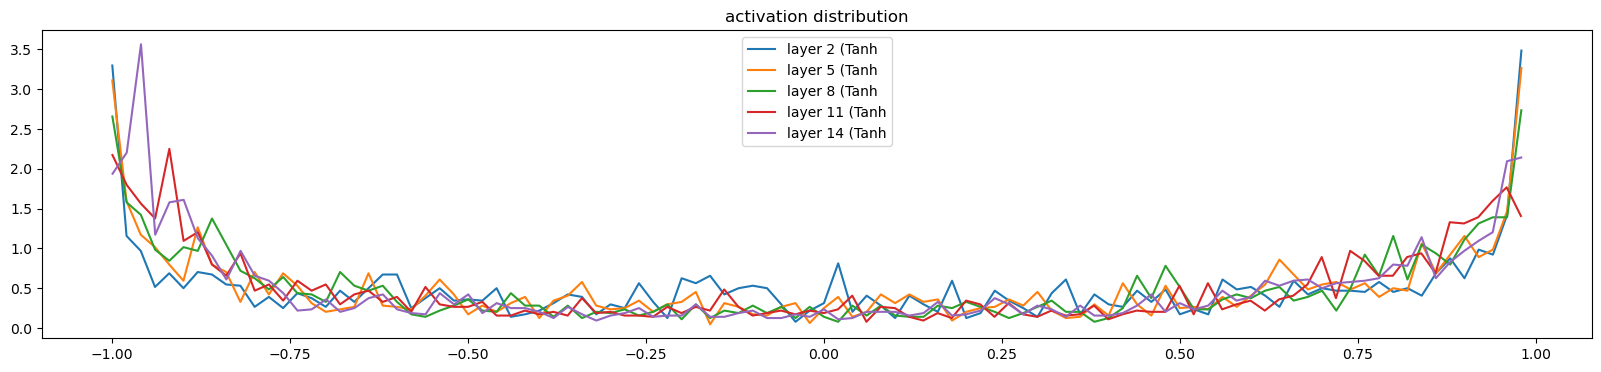

In [78]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.018816e-03
layer 5 (      Tanh): mean -0.000000, std 1.686673e-03
layer 8 (      Tanh): mean +0.000000, std 1.598534e-03
layer 11 (      Tanh): mean +0.000000, std 1.587775e-03
layer 14 (      Tanh): mean -0.000000, std 2.085795e-03


Text(0.5, 1.0, 'gradient distribution')

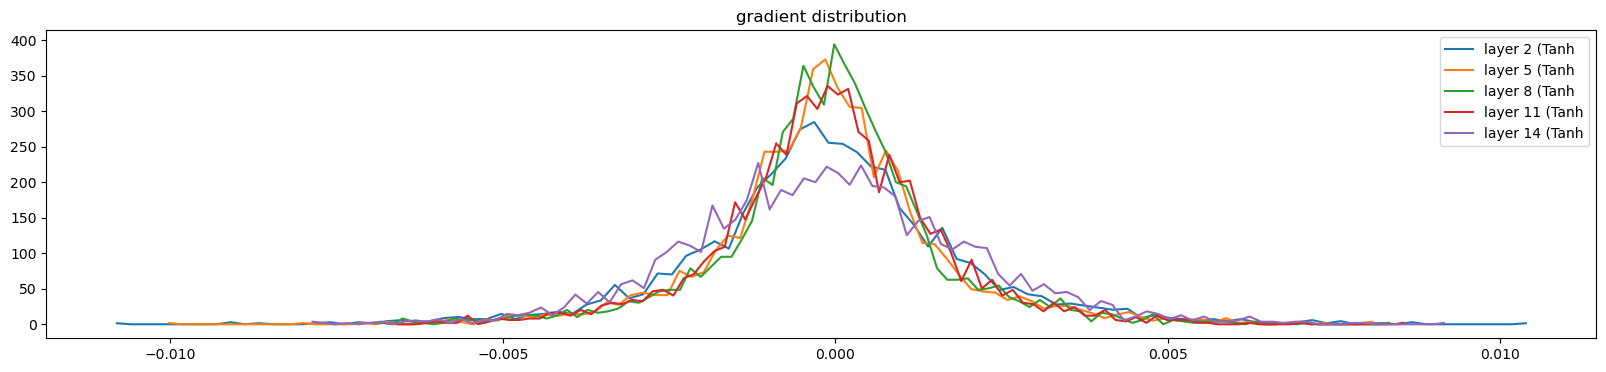

In [79]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

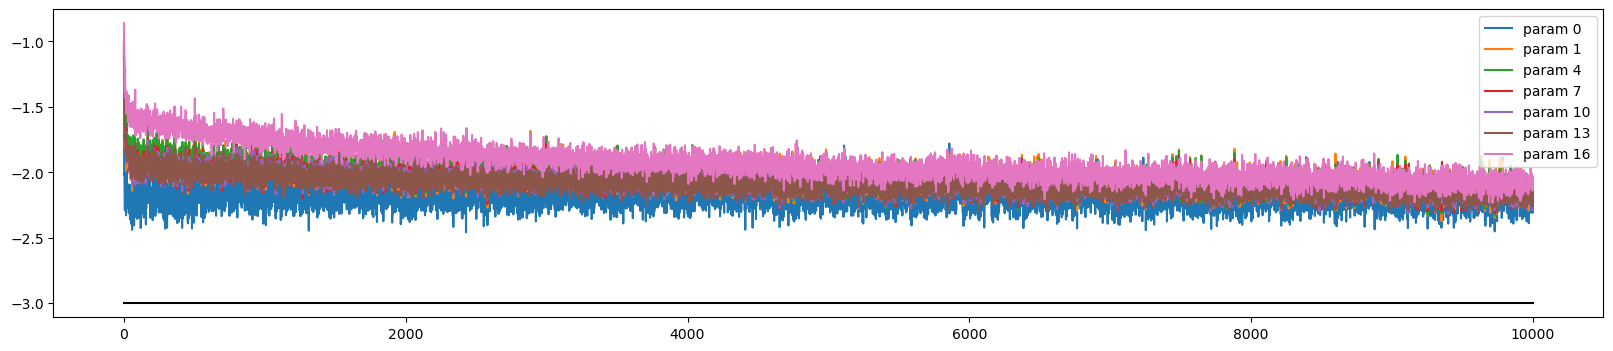

In [80]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);